In [1]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
import mpld3
import numpy as np
import pydot
from IPython.display import SVG, display
from pydrake.systems.framework import LeafSystem_
from pydrake.systems.scalar_conversion import TemplateSystem
from pydrake.autodiffutils import AutoDiffXd
from pydrake.symbolic import Expression
from pydrake.systems.framework import BasicVector, LeafSystem
from pydrake.systems.drawing import plot_system_graphviz
from pydrake.systems.controllers import PidController
from pydrake.solvers import MathematicalProgram, Solve
from pydrake.systems.primitives import AffineSystem, LogVectorOutput
from underactuated import ConfigureParser, running_as_notebook
from underactuated.meshcat_utils import MeshcatSliders
from underactuated.scenarios import AddFloatingRpyJoint
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    ControllabilityMatrix,
    DiagramBuilder,
    Linearize,
    LinearQuadraticRegulator,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Propeller,
    PropellerInfo,
    RigidTransform,
    RobotDiagramBuilder,
    Saturation,
    SceneGraph,
    Simulator,
    StartMeshcat,
    WrapToSystem,
    namedview,
    FirstOrderLowPassFilter,
    ConstantVectorSource
)

if running_as_notebook:
    mpld3.enable_notebook()

In [2]:
class Quaternion:
    def __init__(self, q):
        self.q = np.array(q)
        assert len(self.q) == 4, "Quaternion must have four components"

    @staticmethod
    def from_axis_angle(axis, angle):
        axis = np.asarray(axis)
        axis = axis / np.linalg.norm(axis)
        half_angle = angle / 2
        w = np.cos(half_angle)
        x, y, z = axis * np.sin(half_angle)
        return Quaternion([x, y, z, w])

    def to_rotation_matrix(self):
        q = self.q
        q0, q1, q2, q3 = q[3], q[0], q[1], q[2]
        R = np.array([[1 - 2*q2*q2 - 2*q3*q3, 2*q1*q2 - 2*q3*q0,     2*q1*q3 + 2*q2*q0],
                      [2*q1*q2 + 2*q3*q0,     1 - 2*q1*q1 - 2*q3*q3, 2*q2*q3 - 2*q1*q0],
                      [2*q1*q3 - 2*q2*q0,     2*q2*q3 + 2*q1*q0,     1 - 2*q1*q1 - 2*q2*q2]])
        return R

    def conjugate(self):
        return Quaternion([-self.q[0], -self.q[1], -self.q[2], self.q[3]])

    def norm(self):
        return np.linalg.norm(self.q)

    def normalize(self):
        self.q /= self.norm()

    def __mul__(self, other):
        if isinstance(other, Quaternion):
            w1, x1, y1, z1 = self.q
            w2, x2, y2, z2 = other.q
            w = w1*w2 - x1*x2 - y1*y2 - z1*z2
            x = w1*x2 + x1*w2 + y1*z2 - z1*y2
            y = w1*y2 - x1*z2 + y1*w2 + z1*x2
            z = w1*z2 + x1*y2 - y1*x2 + z1*w2
            return Quaternion([x, y, z, w])
        else:
            raise TypeError("Multiplication with type {} not supported".format(type(other)))

    def rotate_vector(self, v):
        v_quat = Quaternion([v[0], v[1], v[2], 0])
        rotated_v = self * v_quat * self.conjugate()
        return np.array([rotated_v.q[0], rotated_v.q[1], rotated_v.q[2]])

    @staticmethod
    def quat_dot(quat, omega):
        assert omega.shape == (3,1)
        q0, q1, q2, q3 = quat
        G = np.array([
            [-q1, -q2, -q3],
            [ q0, -q3,  q2],
            [ q3,  q0, -q1],
            [-q2,  q1,  q0]
        ])
        quat_dot = G @ omega
        return quat_dot.flatten()

    def to_euler_angles(self):
        """
        Convert a quaternion to Euler angles (roll, pitch, yaw).
    
        Returns:
        euler_angles (array): A 3-element array representing the Euler angles in radians.
        """
        # Extract the quaternion components
        x, y, z, w = self.q
        
        # Roll (x-axis rotation)
        sinr_cosp = 2 * (w * x + y * z)
        cosr_cosp = 1 - 2 * (x * x + y * y)
        roll = np.arctan2(sinr_cosp, cosr_cosp)
    
        # Pitch (y-axis rotation)
        sinp = 2 * (w * y - z * x)
        if np.abs(sinp) >= 1:
            pitch = np.copysign(np.pi / 2, sinp)  # use 90 degrees if out of range
        else:
            pitch = np.arcsin(sinp)
    
        # Yaw (z-axis rotation)
        siny_cosp = 2 * (w * z + x * y)
        cosy_cosp = 1 - 2 * (y * y + z * z)
        yaw = np.arctan2(siny_cosp, cosy_cosp)
    
        return np.array([roll, pitch, yaw])

    def __repr__(self):
        return f"Quaternion({self.q})"


# Simulate Dynamics

## Dynamics Class

In [3]:
@TemplateSystem.define("CompQuad_")
def CompQuad_(T):
    class Impl(LeafSystem_[T]):
        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter=converter)
            self.g = np.array([0, 0, -9.81])
            self.m = 5.8 #kg
            self.L = 0.392 #m
            self.J = np.array([
                [0.16594161, 0.07783639, 0.12138122],
                [0.07783639, 0.20023316, 0.12138122],
                [0.12138122, 0.12138122, 0.24326895]
            ])
            self.kF = 0.01 #thrust coefficient
            self.kM = 0.01 #torque from drag coefficient

            self.v_max = 22.352 #m/s

            # Declare input ports
            self.command = self.DeclareVectorInputPort("u", 4)

            # Declare the continuous state of the system
            self.state_index = self.DeclareContinuousState(13)

            # Declare output port
            self.position = self.DeclareVectorOutputPort(name='Position', size=3, calc=self.CopyPositionOut)
            self.velocity = self.DeclareVectorOutputPort(name="Velocity", size=3, calc=self.CopyVelOut)
            self.attitude = self.DeclareVectorOutputPort(name='Attitude', size=4, calc=self.CopyAttitudeOut)
            self.rates = self.DeclareVectorOutputPort(name='Angular Rates', size=3, calc=self.CopyRatesOut)
            
            #self.DeclareStateOutputPort(name='state', index=self.state_index)

        def DoCalcTimeDerivatives(self, context, derivatives):
            # Extract the state and inputs
            state = context.get_continuous_state_vector().CopyToVector()
            u = self.command.Eval(context)[:]
            u = np.array(u)

            p = state[:3]  # position
            q = Quaternion(state[3:7]) # orientation (quaternion)
            v = state[7:10]  # velocity
            w = state[10:]  # angular velocity

            # Convert the quaternion to a rotation matrix
            #quat = np.array([q[0], q[1], q[2], q[3]]) #[qx qy qz qw]

            w = np.array([w[0], w[1], w[2]])
            Rot_matrix = q.to_rotation_matrix()


            # Calculate the drag term
            Cd_term = np.sqrt(4.0 * ( (self.kF/self.m)**2.0 ) - ( (np.power(self.g, 2.0)) / self.v_max) )
            Cd_term = Cd_term[0]

            # Translational dynamics
            dp = np.array(v)
            
            # Gravitational acceleration with rotation matrix and thrust
            T_hat = np.array([0, 0, np.sum(u)])
            dv = self.g + (1/self.m) * (np.dot(Rot_matrix,T_hat) ) - (Cd_term * dp)
            dv = dv * np.array([1, 1, -1])

            # Quaternion dynamics
            w_quat = Quaternion([0, w[0], w[1], w[2]])
            
            # Using the __mul__ method from the Quaternion class
            q_prod = q * w_quat
            
            # Calculate the quaternion derivative
            w_col = w.reshape((3,1))
            q_dot = (1/2) * Quaternion.quat_dot(q.q, w_col)


            # Rotational dynamics
            tau = self.calculate_torque(u=u[:])

            J_inv = np.linalg.inv(self.J)
            dw = J_inv @ (tau - np.cross(w, (self.J @ w)) )

            state_dot = np.concatenate([dp, q_dot, dv, dw])

            derivatives.SetFromVector(state_dot[:])

        def calculate_torque(self, u):
            T1, T2, T3, T4 = u

            tau_x = self.L / (np.sqrt(2) * (T1 + T2 - T3 - T4) + 1e-6)
            tau_y = self.L / (np.sqrt(2) * (-T1 + T2 + T3 - T4) + 1e-6)
            tau_z = self.kM * (T1 - T2 + T3 - T4) + 1e-6
            return np.array([tau_x, tau_y, tau_z])
        
        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        def CopyPositionOut(self, context, output):
            full_state = context.get_continuous_state_vector().CopyToVector()
            p = full_state[:3]  # position
            #xdot = context.get_continuous_state_vector().CopyToVector()
            output.SetFromVector(p[:])

        def CopyVelOut(self, context, output):
            full_state = context.get_continuous_state_vector().CopyToVector()
            v = full_state[7:10]  # position
            #xdot = context.get_continuous_state_vector().CopyToVector()
            output.SetFromVector(v[:])

        def CopyAttitudeOut(self, context, output):
            full_state = context.get_continuous_state_vector().CopyToVector()
            q = full_state[3:7]
            output.SetFromVector(q[:])

        def CopyRatesOut(self, context, output):
            full_state = context.get_continuous_state_vector().CopyToVector()
            w = full_state[10:]  # angular velocity
            output.SetFromVector(w[:])


    return Impl

## Set up dynamics with inital state

In [4]:
import numpy as np
from pydrake.all import Simulator

# Assuming Quaternion class and CompQuad_ class are already defined

# Define a class or function to set up the system
def setup_quadcopter_system():
    # Create an instance of the CompQuad_ system
    quadcopter_system = CompQuad_[None]()

    # Initial state: [position, quaternion, velocity, angular velocity]
    initial_state = np.array([0, 0, 0,  # Initial position (x, y, z)
                              1, 0, 0, 0,  # Initial quaternion (w, x, y, z)
                              0, 0, 0,  # Initial velocity (vx, vy, vz)
                              0, 0, 0])  # Initial angular velocity (wx, wy, wz)

    # Set initial state
    context = quadcopter_system.CreateDefaultContext()
    context.SetContinuousState(initial_state)

    return quadcopter_system, context


## Setup Data Logging

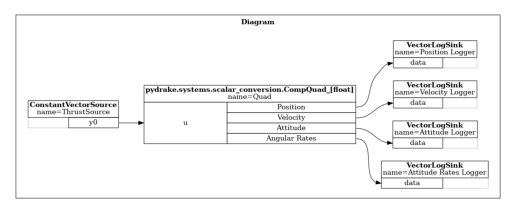

In [5]:
# Create a diagram builder
dynamics_builder = DiagramBuilder()

# Add the quadrotor system
quad_dynamics, context = setup_quadcopter_system()
quad_dynamics = dynamics_builder.AddNamedSystem('Quad', quad_dynamics)

# Set input commands (thrusts of the quadcopter motors)
u = np.array([17.07, 17.07, 10.07, 10.07])  # Constant thrust values for each motor
#u = np.array([0, 0, 0, 0])
thrust_source = dynamics_builder.AddNamedSystem('ThrustSource', ConstantVectorSource(u))
dynamics_builder.Connect(thrust_source.get_output_port(), quad_dynamics.get_input_port(0))

#Log the output of the quadrotor dynamics
logger_pos = LogVectorOutput(quad_dynamics.get_output_port(0), dynamics_builder)
logger_pos.set_name("Position Logger")

logger_vel = LogVectorOutput(quad_dynamics.get_output_port(1), dynamics_builder)
logger_vel.set_name("Velocity Logger")

logger_attitude = LogVectorOutput(quad_dynamics.get_output_port(2), dynamics_builder)
logger_attitude.set_name("Attitude Logger")

logger_rates = LogVectorOutput(quad_dynamics.get_output_port(3), dynamics_builder)
logger_rates.set_name("Attitude Rates Logger")
dynamics_diagram = dynamics_builder.Build()


plot_system_graphviz(dynamics_diagram)
plt.plot('quadrotor_system_diagram.png')

## Simulate and log system

In [ ]:
from pydrake.all import Simulator

# Create a simulator
simulator = Simulator(dynamics_diagram)

# Initialize the simulator's context
simulator_context = simulator.get_mutable_context()
simulator_context.SetTime(0)

# Set simulation parameters
start_time = 0.0
end_time = 100.0  # for example, simulate for 10 seconds

# Run the simulation
simulator.AdvanceTo(end_time)

# Retrieve logged data
position_data = logger_pos.FindLog(simulator_context).data()
position_log = logger_pos.FindLog(simulator_context)
sample_times = position_log.sample_times()


velocity_data = logger_vel.FindLog(simulator_context).data()

attitude_rates_data = logger_rates.FindLog(simulator_context).data()

# Plot the data using matplotlib or a similar library
import matplotlib.pyplot as plt

# Example of plotting position data for x, y, z components individually
plt.figure(figsize=(12, 4))

# Plot x component of position
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
plt.plot(sample_times, position_data[0, :])
plt.xlabel('Time [s]')
plt.ylabel('X Position')
plt.title('Quadcopter X Position Over Time')

# Plot y component of position
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
plt.plot(sample_times, position_data[1, :])
plt.xlabel('Time [s]')
plt.ylabel('Y Position')
plt.title('Quadcopter Y Position Over Time')

# Plot z component of position
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
plt.plot(sample_times, position_data[2, :])
plt.xlabel('Time [s]')
plt.ylabel('Z Position')
plt.title('Quadcopter Z Position Over Time')

plt.tight_layout()
plt.show()


## Plot 3D Trajectory

In [ ]:
from mpl_toolkits.mplot3d import Axes3D  # Import the 3D plotting tool

# Retrieve logged data as before

# Plot the 3D trajectory
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')  # Create a 3D subplot

# Plot the trajectory using x, y, z positional data
ax.plot(position_data[0, :], position_data[1, :], position_data[2, :], label='Quadcopter Trajectory')

# Add labels and title
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_zlabel('Z Position')
ax.set_title('Quadcopter 3D Trajectory Over Time')
ax.legend()

# Show the plot
plt.show()

## Plot Attitude

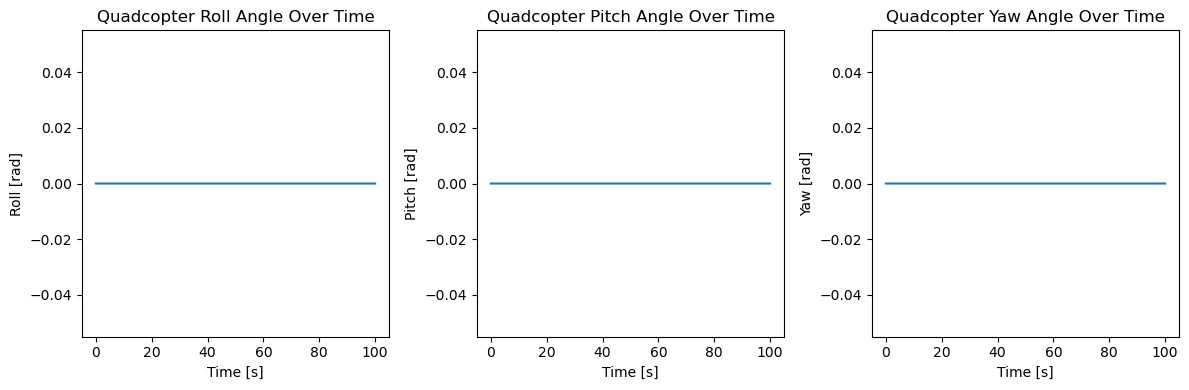

In [95]:
attitude_data = logger_attitude.FindLog(simulator_context).data()
attitude_log = logger_pos.FindLog(simulator_context)
sample_times_attitude = attitude_log.sample_times()

# Initialize lists to store the Euler angles
roll_angles = []
pitch_angles = []
yaw_angles = []

# Convert the quaternion data to Euler angles
for i in range(attitude_data.shape[1]):
    q = Quaternion(attitude_data[:, i])
    euler_angles = q.to_euler_angles()
    roll_angles.append(euler_angles[0])
    pitch_angles.append(euler_angles[1])
    yaw_angles.append(euler_angles[2])

# Convert lists to numpy arrays for plotting
roll_angles = np.array(roll_angles)
pitch_angles = np.array(pitch_angles)
yaw_angles = np.array(yaw_angles)

# Plot the Euler angles using matplotlib
plt.figure(figsize=(12, 4))

# Plot roll angle
plt.subplot(1, 3, 1)
plt.plot(sample_times_attitude, roll_angles)
plt.xlabel('Time [s]')
plt.ylabel('Roll [rad]')
plt.title('Quadcopter Roll Angle Over Time')

# Plot pitch angle
plt.subplot(1, 3, 2)
plt.plot(sample_times_attitude, pitch_angles)
plt.xlabel('Time [s]')
plt.ylabel('Pitch [rad]')
plt.title('Quadcopter Pitch Angle Over Time')

# Plot yaw angle
plt.subplot(1, 3, 3)
plt.plot(sample_times_attitude, yaw_angles)
plt.xlabel('Time [s]')
plt.ylabel('Yaw [rad]')
plt.title('Quadcopter Yaw Angle Over Time')

plt.tight_layout()
plt.show()